<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Wed Jun  5 19:32:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   60C    P0             96W /  350W |   35125MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool, cpu_count
import os
import psutil

###### Parameters 
mag = 1            # Magnitude of the coupling
beta = 1           # Inverse temperature 
alpha = 1            
gamma = 1          # Anharmonic potential U(x) = alpha/2 * x^2 + gamma/4 * x^4
N = 100            # Total number of oscillators in the chain 
dt = 0.01 
delta_t = 0.5
batch = 4000
minibatch = 1
sec_length = 400

Time = 5 * delta_t * sec_length
length = int(Time / dt) + 1
t = np.linspace(0, Time, length) # Define time axis
gap = int(delta_t / dt)
t_store = t[0:-1:gap]

# (q25,q75)
q25_store = np.zeros([t_store.size + 1, batch])    
q75_store = np.zeros([t_store.size + 1, batch])

In [8]:
def solve_sde(batch_idx):
    np.random.seed((batch_idx+1)*100)
    name = multiprocessing.current_process().name        
    print(f'>>>>>>>===============================================\n{name} starting. \nparent process:{os.getppid()}------process id:{os.getpid()}\n===============================================>>>>>>>\n')    
    
    p0 = np.zeros((N, minibatch))
    q0 = np.zeros((N, minibatch))
    p1 = np.zeros((N, minibatch))
    q1 = np.zeros((N, minibatch))

    local_q25_store = np.zeros([t_store.size + 1, minibatch])    
    local_q75_store = np.zeros([t_store.size + 1, minibatch])

    j = 1
    for i in range(1, length):
        q1 = q0 + dt * (p0 - np.roll(p0, 1, axis=0))
        p1 = (1 - mag * dt) * p0 + dt * alpha * (np.roll(q0, -1, axis=0) - q0) + \
             dt * gamma * (np.roll(q0, -1, axis=0)**3 - q0**3) + \
             np.sqrt(2 * dt * gamma / beta) * np.random.randn(N, minibatch)
        if i % gap == 0:
            local_q25_store[j,:] = np.sum(q1[0:25,:], axis=0)
            local_q75_store[j,:] = np.sum(q1[0:75,:], axis=0)
            j += 1
        p0 = p1
        q0 = q1
    
    print(f"Batch {batch_idx} completed. \n")
    return batch_idx, local_q25_store, local_q75_store

In [9]:
if __name__ == '__main__':
    start = time.time()
    test_batch = int(batch / minibatch)
    num_cores = cpu_count()
    with Pool(num_cores) as pool:
        results = pool.map(solve_sde, range(test_batch))
    pool.close()
    pool.join()
    
    end = time.time()
    
    print(f'total runtime: {end-start}')

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-5 sta

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1663402------process id:1663597
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1663402------process id:1663598
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1663402------process id:1663601
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWork

Batch 64 completed. 
>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>



Batch 992 completed. 





Batch 192 completed. 


Batch 512 completed. 
Batch 224 completed. 


Batch 368 completed. 

Batch 896 completed. 


>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-43 starting. 



>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 257 completed. 
Batch 465 completed. 


>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1663402------process id:1663579
===============================================>>>>>>>
>>>>>>>=========





>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
===============================================>>>>>>>

Batch 337 completed. 

Batch 385 completed. 
Batch 417 completed. 

>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
===============================================>>>>>>>

Batch 433 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 849 completed. 
Batch 49 completed. 


>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1663402------pr

Batch 914 completed. 
>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
===============================================>>>>>>>

Batch 66 completed. 

>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1663402------process id:1663554
===============================================>>>>>>>


Batch 242 completed. 


Batch 274 completed. 
>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
==============================


>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1663402------process id:1663585
===============================================>>>>>>>
Batch 194 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 1010 completed. 

>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:1663402------process id:1663613
===============================================>>>>>>>

Batch 626 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>





Batch 691 completed. 
Batch 435 completed. 
Batch 19 completed. 


>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>


Batch 3 completed. 
Batch 339 completed. 


>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
=========

Batch 276 completed. 

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
===============================================>>>>>>>

Batch 84 completed. 

Batch 964 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 804 completed. 


>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600
===============================================>>>>>>>

Batch 100 completed. 

>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
=========

Batch 660 completed. 


>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 580 completed. 

>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:1663402------process id:1663586
===============================================>>>>>>>
Batch 644 completed. 


>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>


Batch 420 completed. 
Batch 820 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1663402------process id:1663576
======

Batch 501 completed. 
Batch 949 completed. 


Batch 293 completed. 

>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-60 starting. 
parent process:1663402------process id:1663609
===============================================>>>>>>>
Batch 517 completed. 



>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1663402------process id:1663582
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-14 starting. 
parent process:1663402------process id:1663563
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
============================


Batch 469 completed. 

>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1663402------process id:1663579
===============================================>>>>>>>

Batch 1013 completed. 

>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:1663402------process id:1663613
===============================================>>>>>>>

Batch 709 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 933 completed. 

>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1663402------process id:1663608
===============================================>>>>>>>

Batch 37 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
======


Batch 406 completed. 

Batch 374 completed. 
Batch 742 completed. 
>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>

Batch 182 completed. 

Batch 662 completed. 
>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
======


>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
===============================================>>>>>>>
Batch 391 completed. 


>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
===============================================>>>>>>>
Batch 967 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>


Batch 295 completed. 
Batch 727 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
=============================


>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 647 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

Batch 551 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>

Batch 631 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 823 completed. 

Batch 311 completed. 

>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1663402------process id:1663569
=====


Batch 8 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
===============================================>>>>>>>
Batch 344 completed. 

Batch 376 completed. 
>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

Batch 872 completed. 


>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
===============================================>>>>>>>


Batch 120 completed. 

>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>

Batch 664 completed. 

>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------proc


>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1663402------process id:1663578
===============================================>>>>>>>

Batch 488 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 265 completed. 

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1663402------process id:1663566
===============================================>>>>>>>

Batch 809 completed. 

>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600
===============================================>>>>>>>

Batch 777 completed. 
Batch 281 completed. 

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
======


>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1663402------process id:1663603
===============================================>>>>>>>


Batch 201 completed. 


>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>

Batch 233 completed. 
Batch 601 completed. 


>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>



>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>
Batch 842 completed. 

Batch 154 completed. 


>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1663402------process id:1663559
===============================================>>>>>>>

Batch 970 completed. 


>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>
Batch 538 completed. 
Batch 362 completed. 

>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
======


>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1663402------process id:1663585
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1663402------process id:1663569
===============================================>>>>>>>

Batch 474 completed. 

>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1663402------process id:1663579
===============================================>>>>>>>

Batch 986 completed. 

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
===============================================>>>>>>>

Batch 618 completed. 


>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>


Batch 411 completed. 


>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:1663402------process id:1663575
===============================================>>>>>>>


Batch 347 completed. 

Batch 907 completed. 

Batch 523 completed. 

>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1663402------process id:1663582
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>


Batch 11 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
=====




>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>
Batch 780 completed. 
>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:1663402------process id:1663599
===============================================>>>>>>>




>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1663402------process id:1663598
===============================================>>>>>>>
Batch 108 completed. 

>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
===============================================>>>>>>>


Batch 172 comple

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>


Batch 604 completed. 

>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>

Batch 28 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>
Batch 428 completed. 

Batch 652 completed. 


>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1663402------process id:1663576
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
================================


>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
===============================================>>>>>>>
Batch 93 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
===============================================>>>>>>>

Batch 381 completed. 

Batch 669 completed. 
Batch 845 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>
Batch 413 completed. 


>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:1663402------process id:1663575
=========


Batch 557 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>

Batch 1021 completed. 

>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:1663402------process id:1663613
===============================================>>>>>>>

Batch 941 completed. 

>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1663402------process id:1663608
===============================================>>>>>>>

Batch 45 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 461 completed. 

>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1663402------process id:1663578
======


>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
===============================================>>>>>>>

Batch 190 completed. 
Batch 526 completed. 


>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1663402------process id:1663582
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>

Batch 862 completed. 

>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1663402------process id:1663603
===============================================>>>>>>>

Batch 238 completed. 
Batch 446 completed. 


>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
=====

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 735 completed. 


>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>

Batch 543 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
===============================================>>>>>>>

Batch 879 completed. 

>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
===============================================>>>>


Batch 479 completed. 

>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1663402------process id:1663579
===============================================>>>>>>>

Batch 639 completed. 

Batch 671 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
===============================================>>>>>>>
Batch 623 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>


Batch 31 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
=======




>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>

Batch 1408 completed. 
Batch 1456 completed. 
Batch 1424 completed. 



>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:1663402------process id:1663575
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>


Batch 1472 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
========================


Batch 2016 completed. 
Batch 2032 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 1025 completed. 
Batch 1041 completed. 

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1663402------process id:1663566
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
===============================================>>>>>>>

Batch 1089 completed. 

>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
=

Batch 1585 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>


Batch 1649 completed. 

>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1663402------process id:1663554
===============================================>>>>>>>

Batch 1617 completed. 

>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
===============================================>>>>>>>

Batch 1665 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 1729 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
=


Batch 1138 completed. 

>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1663402------process id:1663598
===============================================>>>>>>>

Batch 1250 completed. 

>>>>>>>===============================================
ForkPoolWorker-60 starting. 
parent process:1663402------process id:1663609
===============================================>>>>>>>

Batch 1394 completed. 
Batch 1186 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>

Batch 1298 completed. 


>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
==


Batch 1810 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 1906 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

Batch 1890 completed. 

Batch 1874 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1663402------process id:1663569
===============================================>>>>>>>


Batch 1858 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
=


Batch 1411 completed. 

>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:1663402------process id:1663575
===============================================>>>>>>>

Batch 1555 completed. 
Batch 1539 completed. 

>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>

Batch 1491 completed. 

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

Batch 1459 completed. 


>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
==


Batch 1028 completed. 

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1663402------process id:1663566
===============================================>>>>>>>

Batch 1092 completed. 
Batch 1076 completed. 

>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:1663402------process id:1663599
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>

Batch 1060 completed. 
Batch 1348 completed. 


>>>>>>>===============================================
ForkPoolWorker-14 starting. 
parent process:1663402------process id:1663563
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567



Batch 1604 completed. 

Batch 1668 completed. 
>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1663402------process id:1663603
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 1716 completed. 

>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>

Batch 1684 completed. 

>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>

Batch 1764 completed. 

>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1663402------process id:1663585


Batch 1333 completed. 
>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
===============================================>>>>>>>


Batch 1365 completed. 


>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>
Batch 1381 completed. 

>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>
Batch 1317 completed. 


>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
==========================


Batch 1877 completed. 
Batch 1925 completed. 


>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1663402------process id:1663569
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:1663402------process id:1663586
===============================================>>>>>>>


Batch 1861 completed. 

Batch 1941 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>


Batch 1957 completed. 

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
=


Batch 1430 completed. 

Batch 1654 completed. 
>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1663402------process id:1663554
===============================================>>>>>>>

Batch 1462 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>
Batch 1526 completed. 


Batch 1734 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
===


Batch 1031 completed. 

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1663402------process id:1663566
===============================================>>>>>>>

Batch 1063 completed. 
Batch 1207 completed. 

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
===============================================>>>>>>>

Batch 1223 completed. 


>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
===============================================>>>>>>>

Batch 1127 completed. 

Batch 1399 completed. 
>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402--



>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1663402------process id:1663601
===============================================>>>>>>>
Batch 1671 completed. 


>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 1687 completed. 

>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>

Batch 1831 completed. 
Batch 1847 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
=======================

Batch 1368 completed. 


>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>

Batch 1288 completed. 

>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
===============================================>>>>>>>

Batch 1384 completed. 

>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>

Batch 1304 completed. 

Batch 1496 completed. 
>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
=


Batch 1864 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>

Batch 1976 completed. 

>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1663402------process id:1663608
===============================================>>>>>>>

Batch 1960 completed. 

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
===============================================>>>>>>>

Batch 2040 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 2024 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
==


Batch 1545 completed. 

Batch 1321 completed. 
>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 1641 completed. 

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>

Batch 1513 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>

Batch 1593 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
==



>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
===============================================>>>>>>>

Batch 1178 completed. 

>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>
Batch 1098 completed. 


>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>

Batch 1130 completed. 
Batch 1114 completed. 

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600
=========================


Batch 1690 completed. 

>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>

Batch 1450 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1663402------process id:1663597
===============================================>>>>>>>

Batch 1850 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 1818 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 1754 completed. 

>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1663402------process id:1663570




Batch 1307 completed. 
Batch 1499 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

Batch 1195 completed. 
Batch 1275 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1663402------process id:1663559
===============================================>>>>>>>


Batch 1563 completed. 

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571


Batch 1963 completed. 

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
===============================================>>>>>>>

Batch 2027 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 2011 completed. 

>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1663402------process id:1663578
===============================================>>>>>>>

Batch 1995 completed. 

>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:1663402------process id:1663613
===============================================>>>>>>>

Batch 1052 completed. 

>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
=


Batch 1724 completed. 

>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>

Batch 1516 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>

Batch 1596 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 1772 completed. 

>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1663402------process id:1663585
===============================================>>>>>>>

Batch 1836 completed. 

>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591


Batch 1373 completed. 

Batch 1133 completed. 


>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>
Batch 1117 completed. 
>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>
Batch 1165 completed. 




Batch 1261 completed. 
>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>


Batch 1245 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402--


Batch 1821 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 1453 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1663402------process id:1663597
===============================================>>>>>>>

Batch 1917 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

Batch 1789 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1663402------process id:1663576
===============================================>>>>>>>

Batch 1933 completed. 

>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:1663402------process id:1663586


>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1663402------process id:1663559
===============================================>>>>>>>


Batch 1566 completed. 

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>

Batch 1502 completed. 

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

Batch 1742 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>

Batch 1534 completed. 
Batch 1438 completed. 


>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602



Batch 1998 completed. 

>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:1663402------process id:1663613
===============================================>>>>>>>

Batch 1215 completed. 

>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
===============================================>>>>>>>

Batch 1231 completed. 

>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
===============================================>>>>>>>

Batch 1087 completed. 

>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:1663402------process id:1663599
===============================================>>>>>>>

Batch 1071 completed. 

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567


>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 1711 completed. 

>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1663402------process id:1663601
===============================================>>>>>>>

Batch 1583 completed. 

>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1663402------process id:1663582
===============================================>>>>>>>

Batch 1631 completed. 

Batch 1615 completed. 
>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
=========================


>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>

Batch 2288 completed. 
Batch 2272 completed. 

Batch 2304 completed. 

>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>

Batch 2320 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
==========================


Batch 2880 completed. 

>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:1663402------process id:1663586
===============================================>>>>>>>

Batch 2896 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1663402------process id:1663576
===============================================>>>>>>>

Batch 2912 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>

Batch 2928 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 2944 completed. 

>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1663402------process id:1663569



Batch 2401 completed. 

>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1663402------process id:1663554
===============================================>>>>>>>

Batch 2497 completed. 

>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>

Batch 2529 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>

Batch 2545 completed. 

>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
===============================================>>>>>>>

Batch 2561 completed. 
Batch 2513 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402-----


Batch 2098 completed. 

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
===============================================>>>>>>>
Batch 2050 completed. 


>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
===============================================>>>>>>>

Batch 2130 completed. 

>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>

Batch 2114 completed. 

>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
===============================================>>>>>>>

Batch 2146 completed. 

>>>>>>>===============================================
ForkPoolWorker-14 starting. 
parent process:1663402------process id:1663563
=


Batch 2738 completed. 

>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1663402------process id:1663603
===============================================>>>>>>>

Batch 2754 completed. 
Batch 2722 completed. 


>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1663402------process id:1663579
===============================================>>>>>>>

Batch 2690 completed. 

>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1663402------process id:1663601
===============================================>>>>>>>

Batch 2786 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588



Batch 2371 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>

Batch 2387 completed. 

>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1663402------process id:1663559
===============================================>>>>>>>
Batch 2275 completed. 


>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
===============================================>>>>>>>

Batch 2419 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

Batch 2323 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
=


Batch 2931 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 2947 completed. 

>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1663402------process id:1663569
===============================================>>>>>>>

Batch 2963 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>
Batch 2995 completed. 


>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>

Batch 2979 completed. 

>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1663402------process id:1663608
=



>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>

Batch 2436 completed. 


>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
===============================================>>>>>>>

Batch 2580 completed. 

>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:1663402------process id:1663575
===============================================>>>>>>>

Batch 2596 completed. 

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>


>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
===============================================>>>>>>>

Batch 2149 completed. 

>>>>>>>===============================================
ForkPoolWorker-14 starting. 
parent process:1663402------process id:1663563
===============================================>>>>>>>

Batch 2181 completed. 

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1663402------process id:1663566
===============================================>>>>>>>

Batch 2245 completed. 

Batch 2261 completed. 
>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>


Batch 2165 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560


Batch 2725 completed. 

>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
===============================================>>>>>>>


Batch 2789 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 2805 completed. 

>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1663402------process id:1663570
===============================================>>>>>>>
Batch 2821 completed. 


>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1663402------process id:1663587
===============================================>>>>>>>

Batch 2773 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605



Batch 2326 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
===============================================>>>>>>>
Batch 2358 completed. 


>>>>>>>===============================================
ForkPoolWorker-60 starting. 
parent process:1663402------process id:1663609
===============================================>>>>>>>

Batch 2502 completed. 

>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>

Batch 2278 completed. 
Batch 2486 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
==


Batch 2998 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1663402------process id:1663551
===============================================>>>>>>>

Batch 3014 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 2982 completed. 

>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1663402------process id:1663608
===============================================>>>>>>>

Batch 3030 completed. 

>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
===============================================>>>>>>>

Batch 3046 completed. 

>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1663402------process id:1663578
==


Batch 2615 completed. 
Batch 2647 completed. 


>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>


Batch 2599 completed. 

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>

Batch 2439 completed. 

>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
===============================================>>>>>>>

Batch 2663 completed. 

>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1663402------process id:1663585
=


Batch 2168 completed. 

>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>

Batch 2264 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 2248 completed. 

Batch 2312 completed. 
>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>


Batch 2200 completed. 

>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600




Batch 2792 completed. 
Batch 2776 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 2856 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

Batch 2888 completed. 
Batch 2840 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:1663402------process id:1663586

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>
Batch 2281 completed. 

>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1663402------process id:1663574
===============================================>>>>>>>


Batch 2233 completed. 

>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>

Batch 2553 completed. 

>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
===============================================>


>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1663402------process id:1663611
===============================================>>>>>>>

Batch 3049 completed. 

>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1663402------process id:1663578
===============================================>>>>>>>

Batch 2106 completed. 

Batch 2074 completed. 
>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
===============================================>>>>>>>
Batch 2138 completed. 



>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
========================

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>


Batch 2682 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 2410 completed. 

>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1663402------process id:1663554
===============================================>>>>>>>

Batch 2714 completed. 

>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1663402------process id:1663582
===============================================>>>>>>>
Batch 2442 completed. 


>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
==========================


Batch 2315 completed. 

>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>

Batch 2427 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

Batch 2203 completed. 

Batch 2507 completed. 
>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1663402------process id:1663600
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>

Batch 2219 completed. 
Batch 2379 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402---

Batch 2795 completed. 


>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 2843 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 2907 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1663402------process id:1663576
===============================================>>>>>>>

Batch 2923 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>

Batch 2939 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594



Batch 2460 completed. 

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1663402------process id:1663561
===============================================>>>>>>>

Batch 2556 completed. 

>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
===============================================>>>>>>>

Batch 2300 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1663402------process id:1663550
===============================================>>>>>>>

Batch 2572 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 2540 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
=


Batch 2077 completed. 

Batch 2109 completed. 

>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1663402------process id:1663604
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
===============================================>>>>>>>


Batch 2061 completed. 

>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1663402------process id:1663583
===============================================>>>>>>>

Batch 2125 completed. 

>>>>>>>===============================================
ForkPoolWorker-7 starting. 
parent process:1663402------process id:1663556
===============================================>>>>>>>

Batch 2093 completed. 

>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:1663402------process id:1663599
=


Batch 2413 completed. 

>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1663402------process id:1663554
===============================================>>>>>>>

Batch 2733 completed. 

>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
===============================================>>>>>>>

Batch 2701 completed. 

Batch 2445 completed. 
>>>>>>>===============================================
ForkPoolWorker-52 starting. 
parent process:1663402------process id:1663601
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1663402------process id:1663572
===============================================>>>>>>>

Batch 2813 completed. 

>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1663402------process id:1663570
=

Batch 2478 completed. 

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>


Batch 2222 completed. 

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>
Batch 2494 completed. 


>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>

Batch 2382 completed. 

Batch 2350 completed. 
>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1663402------process id:1663598



Batch 2974 completed. 
Batch 2926 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 2942 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 3022 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 2878 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1663402------process id:1663597
=


Batch 2543 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>

Batch 2655 completed. 

>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1663402------process id:1663591
===============================================>>>>>>>

Batch 2575 completed. 

Batch 2623 completed. 

Batch 2527 completed. 
>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
==


Batch 3216 completed. 

>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1663402------process id:1663565
===============================================>>>>>>>

Batch 3232 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3248 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

Batch 3280 completed. 

>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

Batch 3296 completed. 

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612



Batch 3856 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1663402------process id:1663576
===============================================>>>>>>>

Batch 3840 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 3872 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

Batch 3888 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 3920 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580



Batch 3521 completed. 

>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1663402------process id:1663602
===============================================>>>>>>>

Batch 3569 completed. 

>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>

Batch 3585 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>

Batch 3601 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>

Batch 3553 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
=


Batch 3250 completed. 

Batch 3282 completed. 
>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1663402------process id:1663571
===============================================>>>>>>>

Batch 3234 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3298 completed. 

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>

Batch 3266 completed. 

>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
=


Batch 3874 completed. 

>>>>>>>===============================================
ForkPoolWorker-41 starting. 
parent process:1663402------process id:1663590
===============================================>>>>>>>

Batch 3842 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 3938 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>

Batch 3890 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 3906 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589



Batch 3587 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>

Batch 3571 completed. 

>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>

Batch 3603 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>

Batch 3555 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 3619 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
=


Batch 3300 completed. 

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1663402------process id:1663612
===============================================>>>>>>>

Batch 3316 completed. 

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1663402------process id:1663562
===============================================>>>>>>>

Batch 3252 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

Batch 3268 completed. 

>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>

Batch 3236 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
=


Batch 3844 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 3940 completed. 

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1663402------process id:1663584
===============================================>>>>>>>

Batch 3908 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 3924 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 3892 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588



Batch 3605 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>

Batch 3669 completed. 

>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1663402------process id:1663582
===============================================>>>>>>>

Batch 3589 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>

Batch 3557 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 3621 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
=


Batch 3206 completed. 

>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>

Batch 3270 completed. 

>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1663402------process id:1663557
===============================================>>>>>>>

Batch 3254 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

Batch 3238 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3350 completed. 

>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
=


Batch 3846 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 3910 completed. 

>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1663402------process id:1663589
===============================================>>>>>>>

Batch 3926 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 3958 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 3894 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588



Batch 3607 completed. 

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1663402------process id:1663606
===============================================>>>>>>>

Batch 3591 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>

Batch 3623 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 3559 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 3655 completed. 

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
==


Batch 3208 completed. 

>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1663402------process id:1663593
===============================================>>>>>>>

Batch 3256 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

Batch 3240 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3352 completed. 

>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>

Batch 3336 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581



Batch 3928 completed. 

>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1663402------process id:1663580
===============================================>>>>>>>

Batch 3848 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 3960 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 3896 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 3976 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
=


Batch 3705 completed. 

>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1663402------process id:1663564
===============================================>>>>>>>

Batch 3657 completed. 

>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1663402------process id:1663553
===============================================>>>>>>>

Batch 3625 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 3561 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 3593 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
==


Batch 3354 completed. 

>>>>>>>===============================================
ForkPoolWorker-24 starting. 
parent process:1663402------process id:1663573
===============================================>>>>>>>

Batch 3258 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

Batch 3242 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3338 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

Batch 3370 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595



Batch 3850 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1663402------process id:1663605
===============================================>>>>>>>

Batch 3962 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 3898 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 3978 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 3994 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1663402------process id:1663597
=


Batch 3627 completed. 

>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1663402------process id:1663577
===============================================>>>>>>>

Batch 3691 completed. 

>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1663402------process id:1663585
===============================================>>>>>>>

Batch 3467 completed. 

>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1663402------process id:1663559
===============================================>>>>>>>

Batch 3563 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 3595 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
=


Batch 3260 completed. 

>>>>>>>===============================================
ForkPoolWorker-47 starting. 
parent process:1663402------process id:1663596
===============================================>>>>>>>

Batch 3244 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3340 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

Batch 3372 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>

Batch 3388 completed. 

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
=


Batch 3964 completed. 

>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1663402------process id:1663594
===============================================>>>>>>>

Batch 3900 completed. 

Batch 3980 completed. 
>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 3085 completed. 

>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1663402------process id:1663568
===============================================>>>>>>>

Batch 3117 completed. 

>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1663402------process id:1663567
=


Batch 3581 completed. 

>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1663402------process id:1663592
===============================================>>>>>>>

Batch 3565 completed. 

>>>>>>>===============================================
ForkPoolWorker-61 starting. 
parent process:1663402------process id:1663610
===============================================>>>>>>>

Batch 3597 completed. 

>>>>>>>===============================================
ForkPoolWorker-9 starting. 
parent process:1663402------process id:1663558
===============================================>>>>>>>

Batch 3469 completed. 

>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1663402------process id:1663559
===============================================>>>>>>>

Batch 3725 completed. 

>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1663402------process id:1663570
=


Batch 3246 completed. 

>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1663402------process id:1663560
===============================================>>>>>>>

Batch 3342 completed. 

>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1663402------process id:1663581
===============================================>>>>>>>

Batch 3390 completed. 
Batch 3374 completed. 


>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1663402------process id:1663595
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1663402------process id:1663555
===============================================>>>>>>>

Batch 3486 completed. 

>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1663402------process id:1663607
=


Batch 3982 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1663402------process id:1663552
===============================================>>>>>>>

Batch 3902 completed. 

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1663402------process id:1663588
===============================================>>>>>>>

Batch 3087 completed. 

Batch 3119 completed. 

Batch 3151 completed. 

Batch 3103 completed. 

Batch 3998 completed. 

>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1663402------process id:1663597
===============================================>>>>>>>

Batch 3135 completed. 

Batch 3199 completed. 

Batch 3167 completed. 

Batch 3231 completed. 

Batch 3183 completed. 

Batch 3295 completed. 

Batch 3327 completed. 

Batch 3311 completed. 

Batch 3279 completed. 

Batch 3359 completed. 

Batch 3215 completed. 

Batch 3

Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

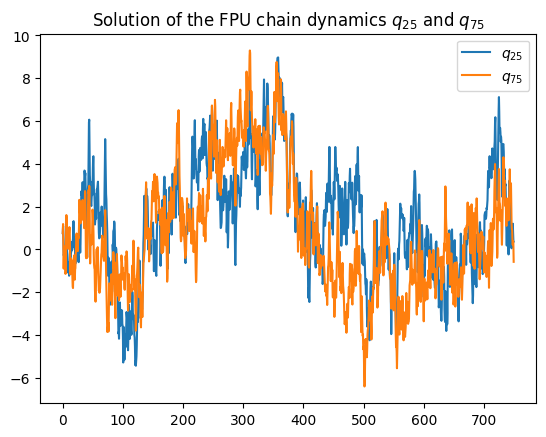

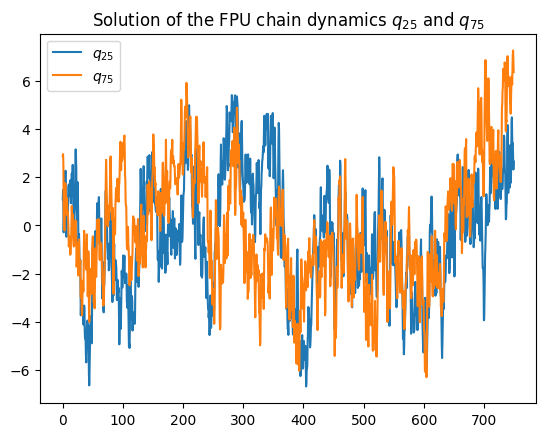

In [10]:
for i, local_q25_store, local_q75_store in results:
        q25_store[:, i*minibatch:(i+1)*minibatch] = local_q25_store
        q75_store[:, i*minibatch:(i+1)*minibatch] = local_q75_store

Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 4000) (400, 4000) (400, 4000)
(400, 4000) (400, 4000, 2)


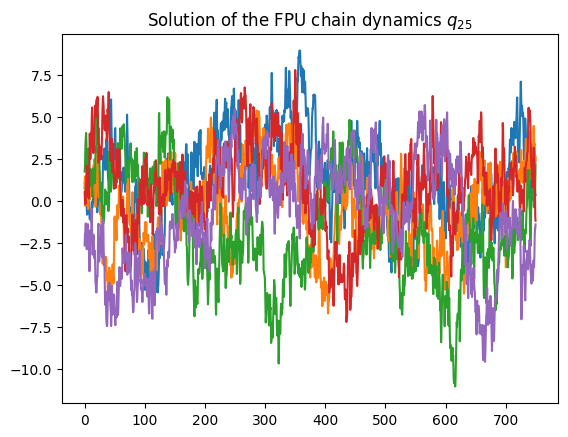

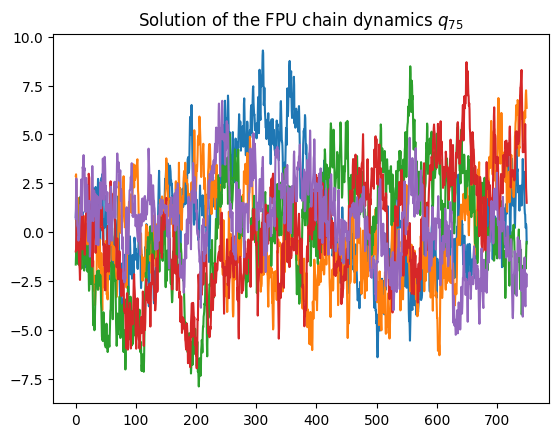

In [11]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [12]:
# Reformulating data into Torch tensors 

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch target size is', target.size(), target.dtype)

The torch target size is torch.Size([400, 4000, 2]) torch.float32


In [13]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


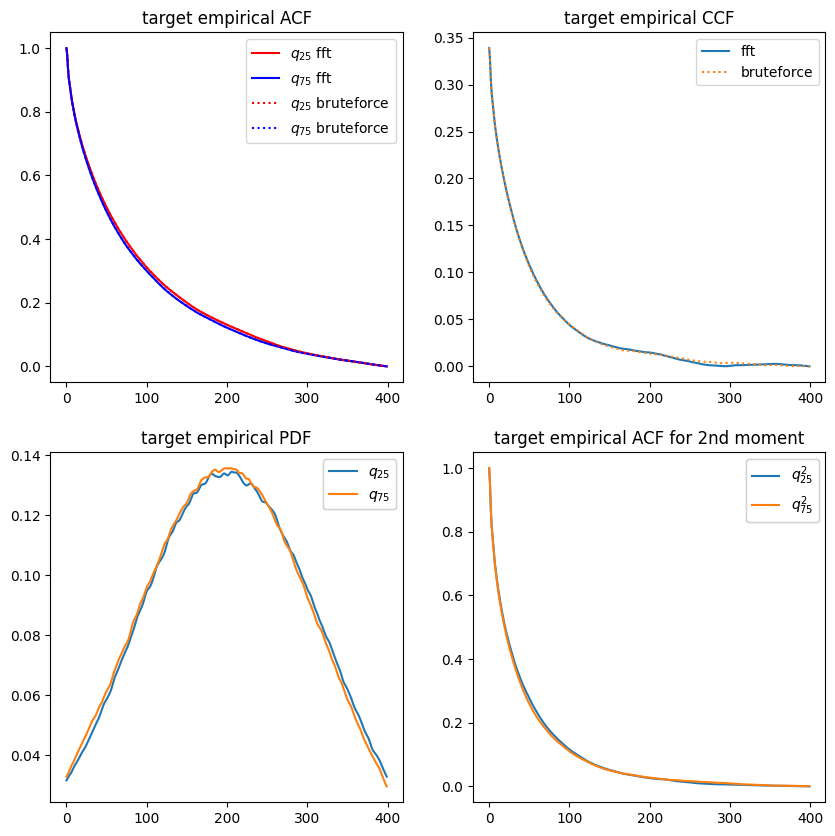

In [14]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

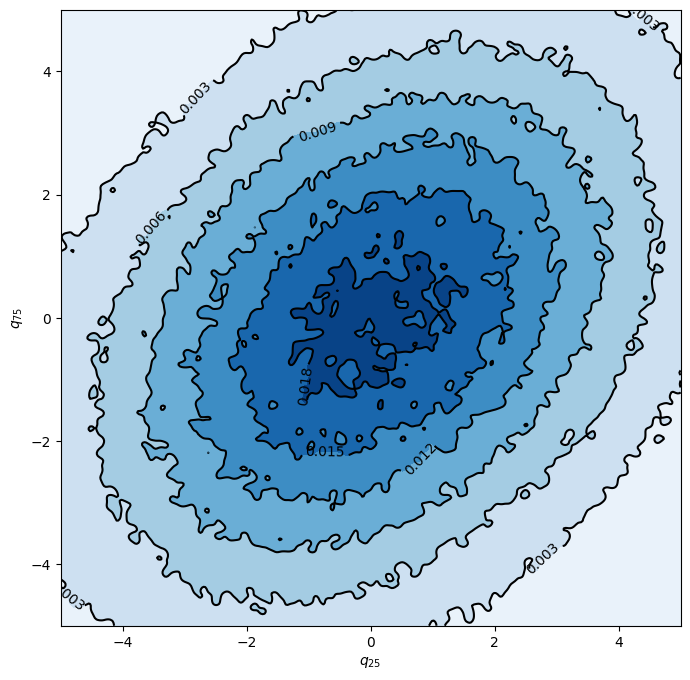

In [15]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

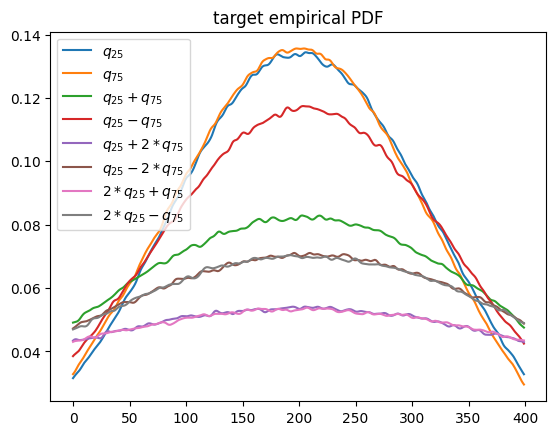

In [16]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [17]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [18]:
batch = 800
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)

target_total = target
target = target[:, :batch, :]
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 800, 2]) torch.float32
The torch validation size is torch.Size([800, 800, 2]) torch.float32
The torch target size is torch.Size([400, 800, 2]) torch.float32


In [19]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2


    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(15000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
#             if acf <=0.0001 and ccf <=0.0001 and pdf<=0.00002 and pdf2<=0.00002 and acf_sec_moment<=0.0001:
#                 break

#         if acf > 0.0001 or ccf > 0.0001 or pdf >0.00002 or pdf2 >0.00002 or acf_sec_moment>0.0001:
#             print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0003 and loss_val <=0.0003:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
#         if acf > 0.0001 or ccf > 0.0001 or pdf >0.00002 or pdf2 >0.00002 or acf_sec_moment>0.0001:
#             print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [20]:
### Defining SINN model
net = SINN(2, 200, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension

In [21]:
model = Model(net=net)

In [22]:
model_type = 1

In [23]:
model.train()

[0]-th step loss: 0.8000, 0.7864, acf: 0.07447, ccf: 0.00490, pdf: 0.33758, pdf2: 0.34437, acf2: 0.02505
[50]-th step loss: 0.0504, 0.0554, acf: 0.02634, ccf: 0.00712, pdf: 0.00851, pdf2: 0.00323, acf2: 0.01022
[100]-th step loss: 0.0399, 0.0402, acf: 0.01536, ccf: 0.01801, pdf: 0.00323, pdf2: 0.00240, acf2: 0.00122
[150]-th step loss: 0.0386, 0.0349, acf: 0.01418, ccf: 0.01541, pdf: 0.00234, pdf2: 0.00200, acf2: 0.00097
[200]-th step loss: 0.0387, 0.0420, acf: 0.02215, ccf: 0.01298, pdf: 0.00329, pdf2: 0.00232, acf2: 0.00128
[250]-th step loss: 0.0101, 0.0118, acf: 0.00087, ccf: 0.00339, pdf: 0.00406, pdf2: 0.00181, acf2: 0.00168
[300]-th step loss: 0.0175, 0.0143, acf: 0.00511, ccf: 0.00295, pdf: 0.00376, pdf2: 0.00171, acf2: 0.00076
[350]-th step loss: 0.0116, 0.0109, acf: 0.00219, ccf: 0.00037, pdf: 0.00451, pdf2: 0.00189, acf2: 0.00195
[400]-th step loss: 0.0392, 0.0373, acf: 0.01489, ccf: 0.01321, pdf: 0.00430, pdf2: 0.00199, acf2: 0.00290
[450]-th step loss: 0.0112, 0.0112, acf:

In [24]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$l_2 loss$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [25]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [26]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [27]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

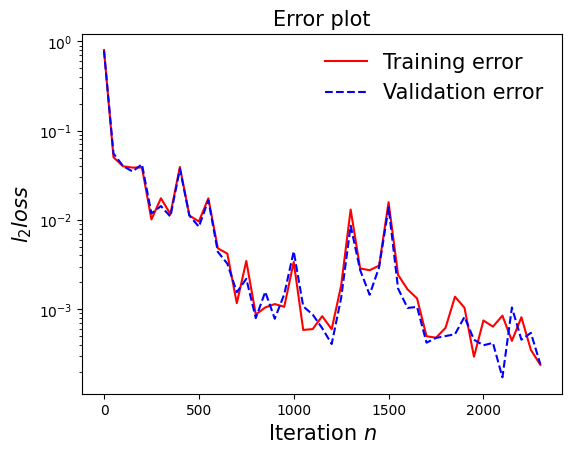

In [28]:
draw_loss(model)

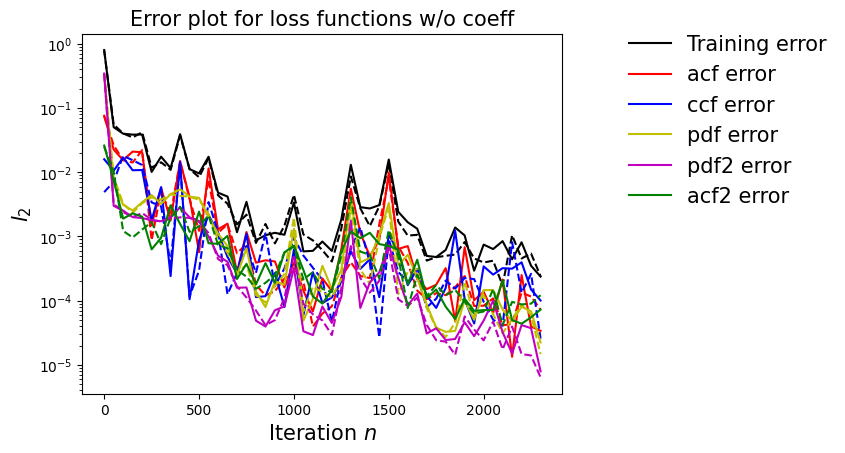

In [29]:
draw_errors(model)

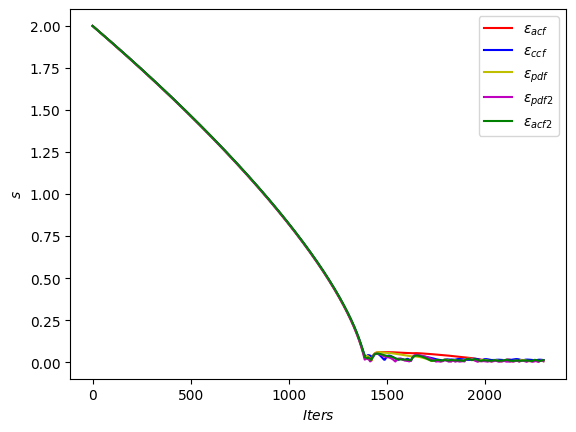

In [30]:
draw_adaptive_w(model)

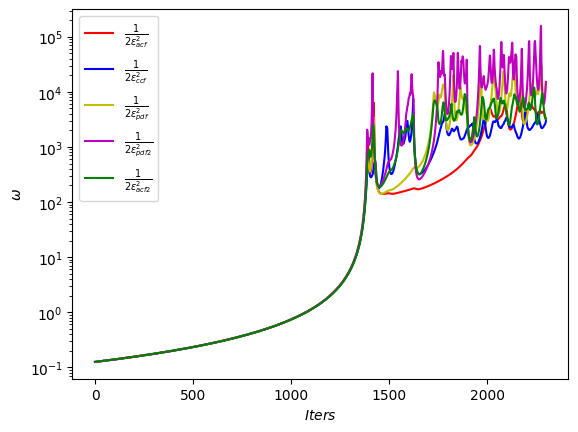

In [31]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [32]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [33]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target_total)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target_total)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [34]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target_total, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target_total, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{49}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{49}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{49}+q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{49}-q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{49}+q_{50}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{49}-q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{49}+2q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{49}-2q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{49}+2\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{49}-2\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{49}+\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{49}-\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{49}+\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{49}-\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [35]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target_total**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{49}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{50}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [36]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [37]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [38]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target_total, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

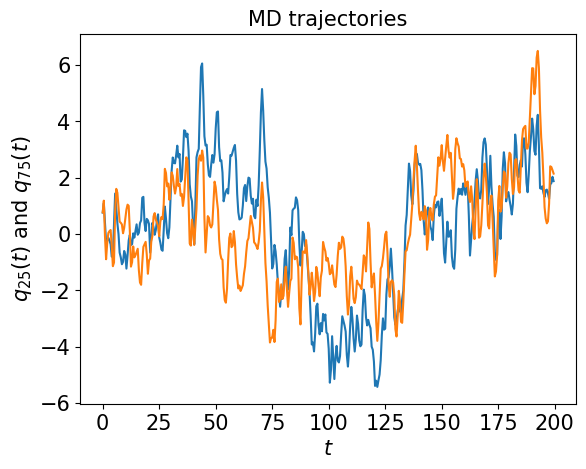

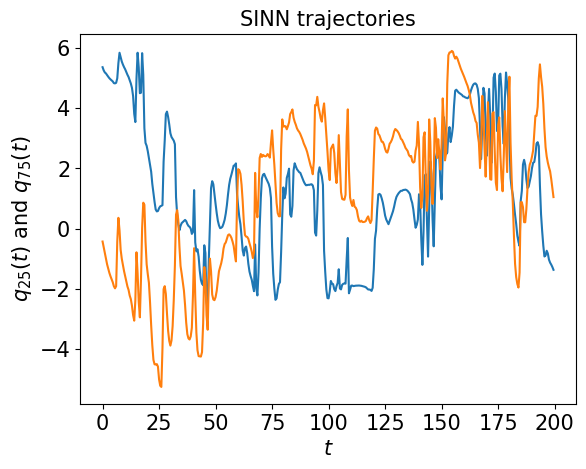

In [39]:
test1(model)

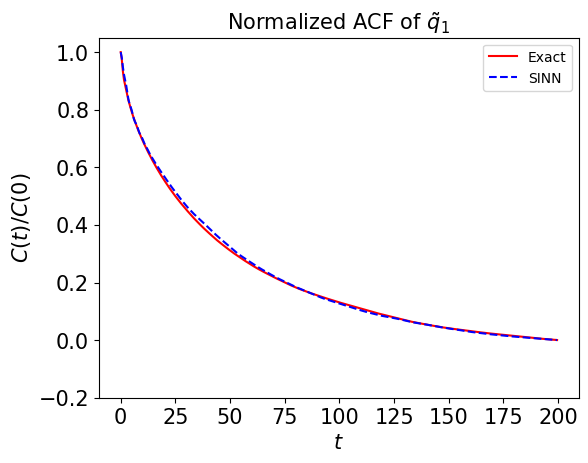

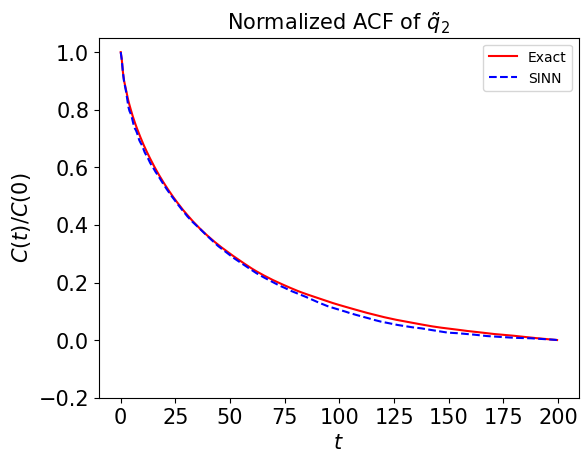

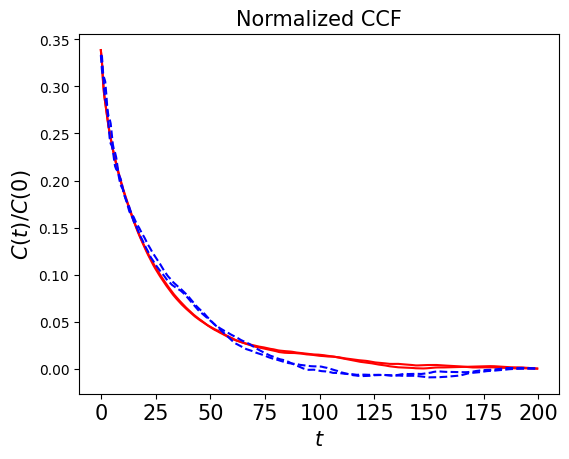

In [40]:
test2(model)

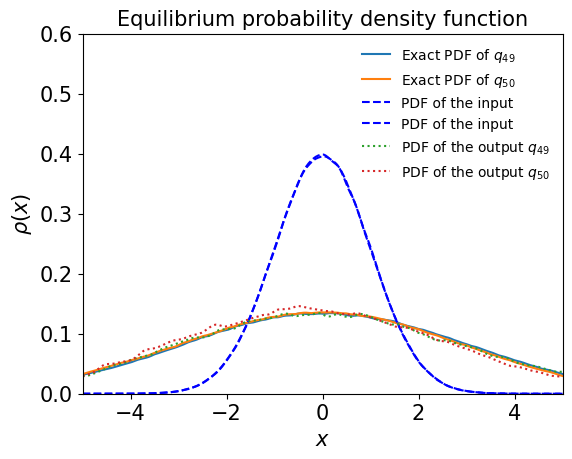

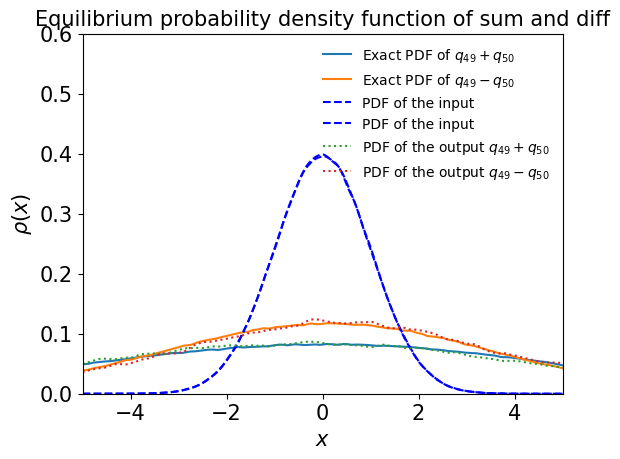

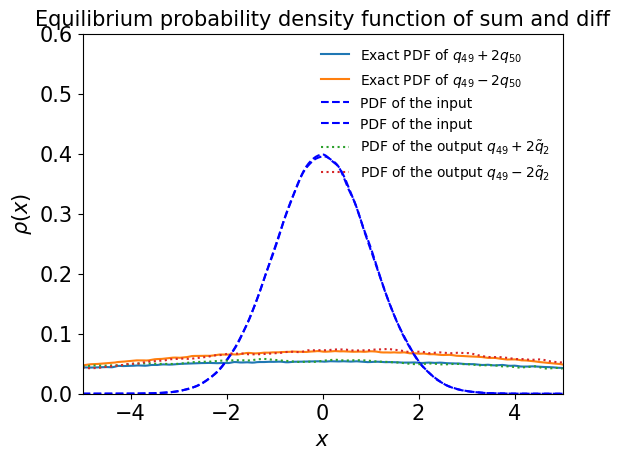

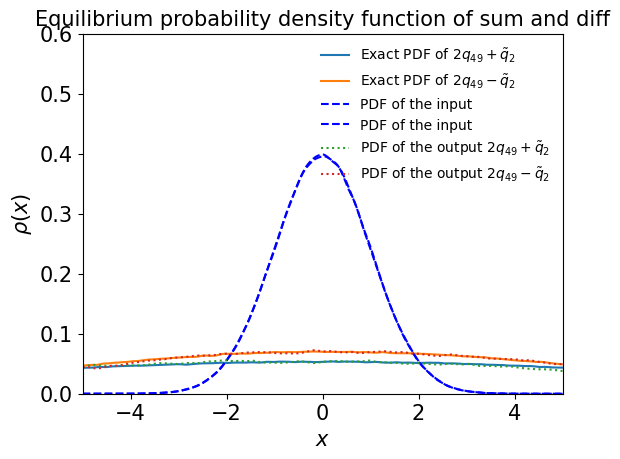

In [41]:
test3(model)

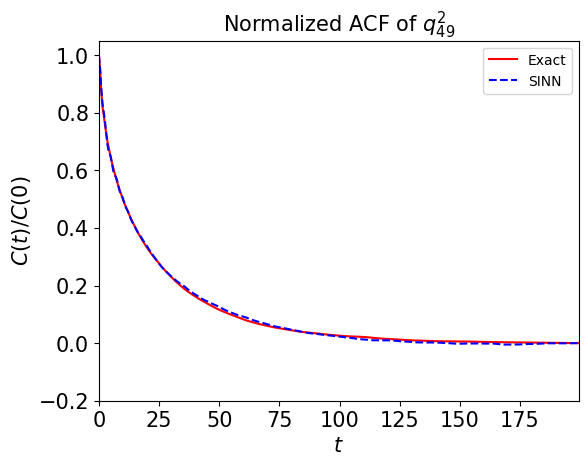

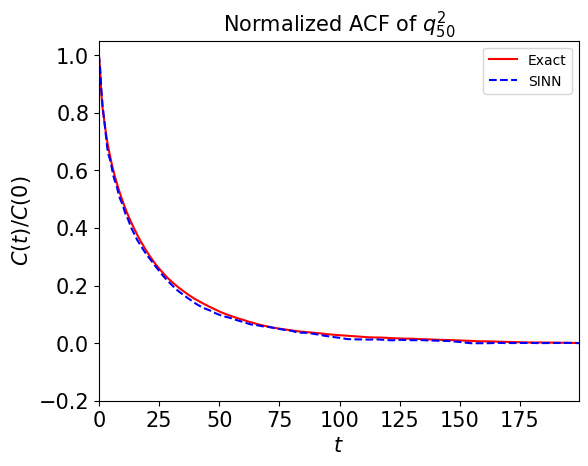

In [42]:
test4(model)

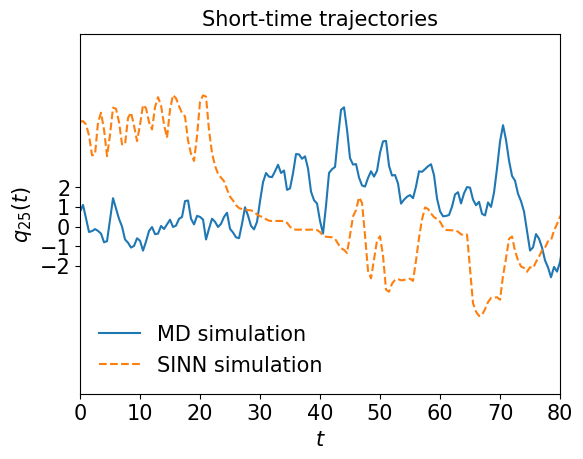

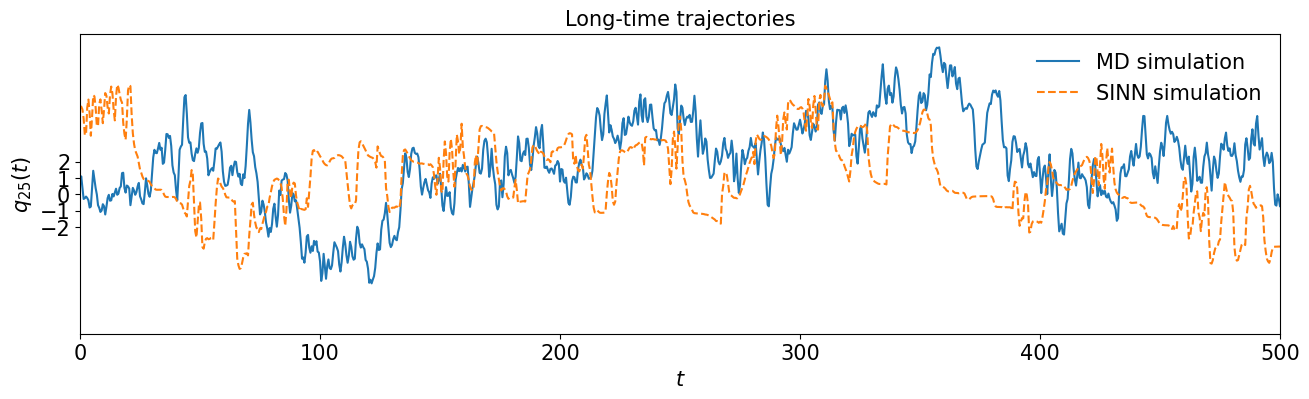

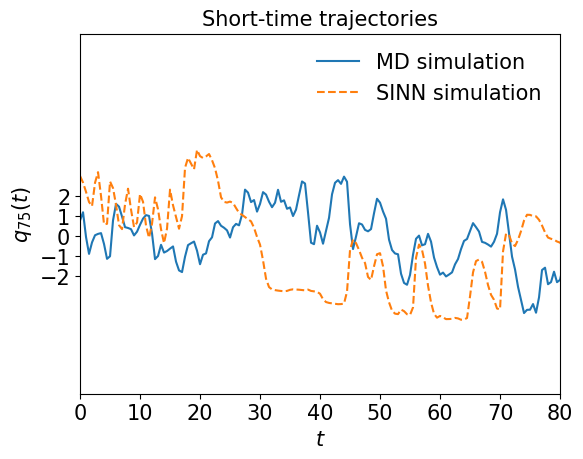

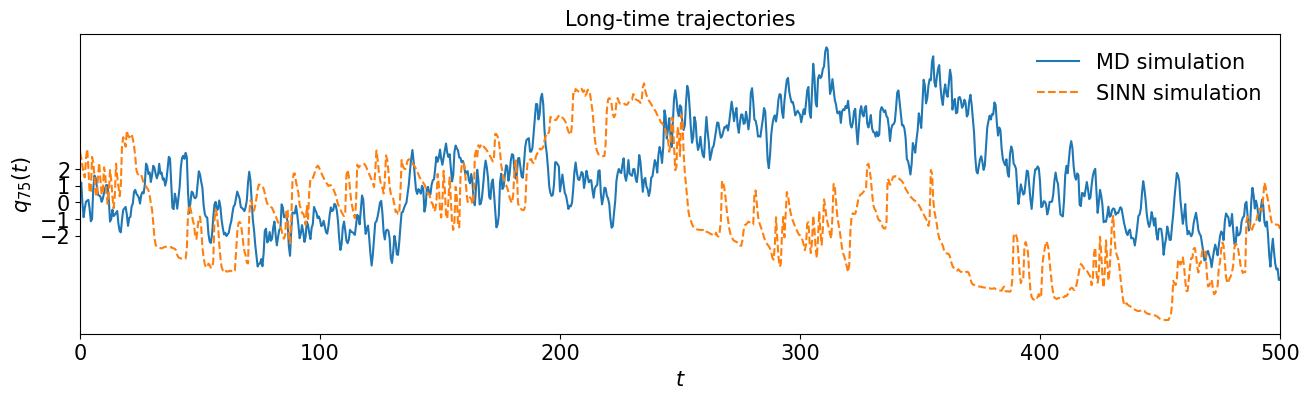

In [43]:
test5(model)

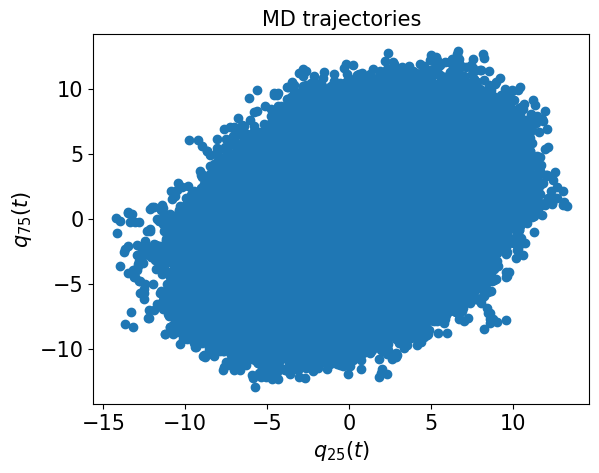

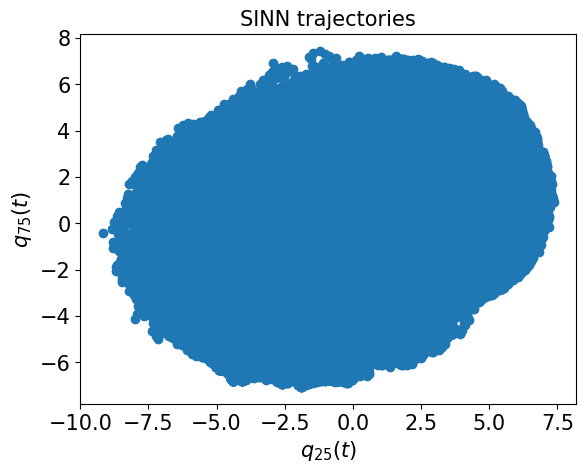

In [44]:
test6(model)

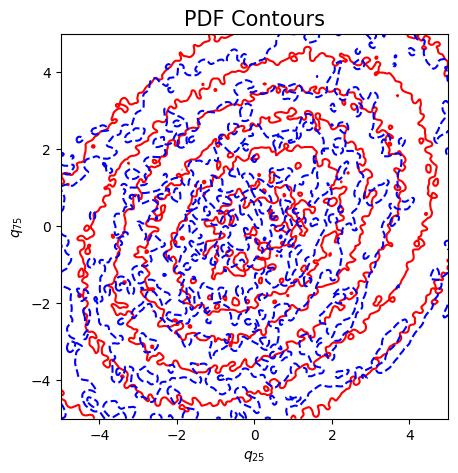

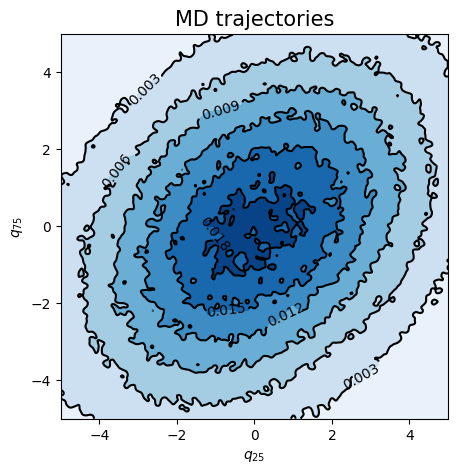

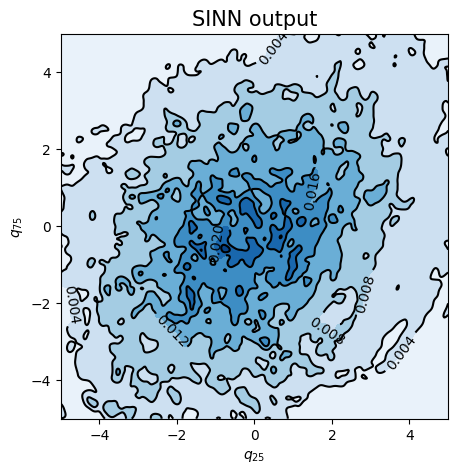

In [45]:
test7(model)